### Chargement des datasets

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


class PVF10Dataset(Dataset):

    def __init__(self, df_pvf10, dico_classes,ensemble,format, transform=None):
        # Filtrer par ensemble (train/test) et par format
        dataframe = df_pvf10.loc[(df_pvf10['Train_Test'] == ensemble) & (df_pvf10['Format'] == format)]
        self.dataframe = dataframe
        self.dico_classes = dico_classes
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Récupérer le chemin de l'image
        img_path = self.dataframe.iloc[idx]["Chemin"]
        image = Image.open(img_path).convert("RGB")  # Ouvrir l'image
        # Récupérer la classe in de l'image
        label_str = self.dataframe.iloc[idx]["Classe"]
        label = self.dico_classes[label_str]  # Convertir string → int

        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        return image,torch.tensor(label, dtype=torch.long)  # Retourne l'image et la classe
    

In [2]:
# Transformation des images (redimensionnement, normalisation)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Certaines archis exigent 3 canaux
    transforms.Resize((224, 224)),  # Taille adaptée à ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

# Création des datasets train et test
df_pvf10 = pd.read_csv('structure_pvf_10.csv')
# Les labels doivent être encodées en entiers pour PyTorch
dico_classes = {classe: idx for idx, classe in enumerate(df_pvf10["Classe"].unique())}
train_dataset = PVF10Dataset(df_pvf10, dico_classes, ensemble='train', format='110x60', transform=transform)
test_dataset = PVF10Dataset(df_pvf10, dico_classes, ensemble='test', format='110x60', transform=transform)

# Chargement par batch
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Entraînement ResNet18

In [3]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Utiliser CUDA si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger un modèle pré-entraîné (ex : ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adapter au nombre de classes
model = model.to(device)

# Définir la fonction de coût et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement sur plusieurs époques
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Boucle d'entraînement
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


d:\Sources\PVF\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Sources\PVF\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.8070343806865109
Epoch 2/10, Loss: 0.46893219279635484
Epoch 3/10, Loss: 0.36751124699404286
Epoch 4/10, Loss: 0.29260274160439803
Epoch 5/10, Loss: 0.2673662429568684
Epoch 6/10, Loss: 0.2252234966511939
Epoch 7/10, Loss: 0.18760539919944705
Epoch 8/10, Loss: 0.16188279178681647
Epoch 9/10, Loss: 0.15653159956975726
Epoch 10/10, Loss: 0.12329880014702582


### Evaluation

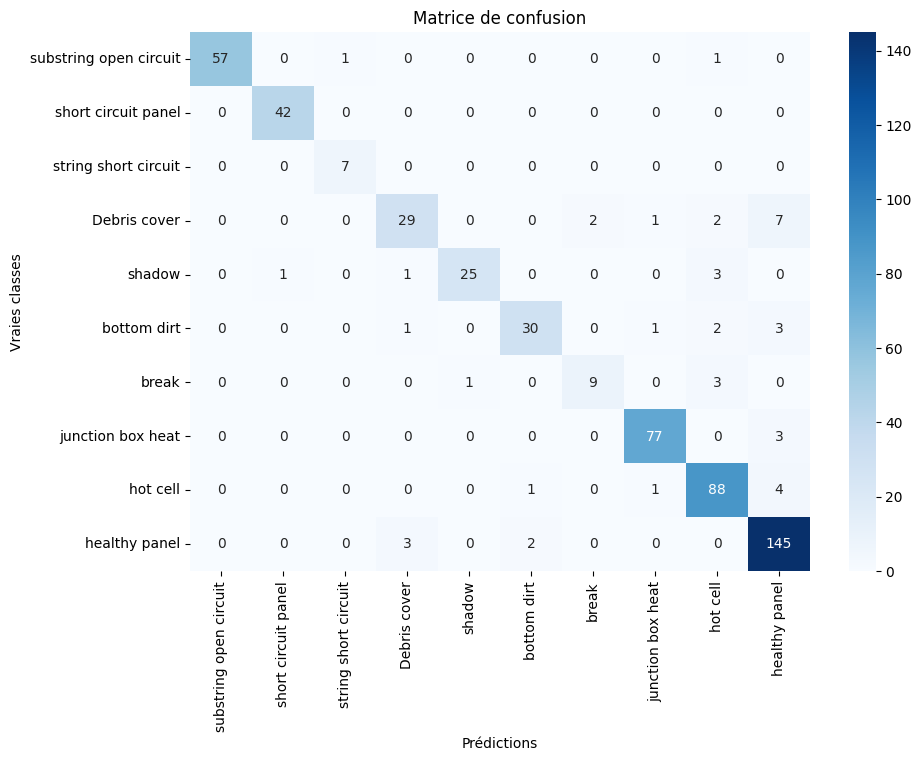

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Prédictions sur l'ensemble de test
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=list(dico_classes.keys()),yticklabels=list(dico_classes.keys()))
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

In [7]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
class_report = classification_report(all_labels, all_preds, target_names=list(dico_classes.keys()))

# Afficher le rapport
print("Rapport de classification :\n", class_report)

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       1.00      0.97      0.98        59
   short circuit panel       0.98      1.00      0.99        42
  string short circuit       0.88      1.00      0.93         7
          Debris cover       0.85      0.71      0.77        41
                shadow       0.96      0.83      0.89        30
           bottom dirt       0.91      0.81      0.86        37
                 break       0.82      0.69      0.75        13
     junction box heat       0.96      0.96      0.96        80
              hot cell       0.89      0.94      0.91        94
         healthy panel       0.90      0.97      0.93       150

              accuracy                           0.92       553
             macro avg       0.91      0.89      0.90       553
          weighted avg       0.92      0.92      0.92       553

